In [1]:
!wget "http://immortal.multicomp.cs.cmu.edu/raw_datasets/old_processed_data/iemocap/data.zip"

--2019-07-15 07:48:05--  http://immortal.multicomp.cs.cmu.edu/raw_datasets/old_processed_data/iemocap/data.zip
Resolving immortal.multicomp.cs.cmu.edu (immortal.multicomp.cs.cmu.edu)... 128.2.211.216
Connecting to immortal.multicomp.cs.cmu.edu (immortal.multicomp.cs.cmu.edu)|128.2.211.216|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311438653 (297M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 297.01M  31.1MB/s    in 9.8s    

2019-07-15 07:48:15 (30.4 MB/s) - ‘data.zip’ saved [311438653/311438653]



In [2]:
!unzip -P "hello_iemocap_2008" data.zip

Archive:  data.zip
   creating: data/
  inflating: data/facet_valid.p      
  inflating: data/facet_test.p       
  inflating: data/covarep_test.p     
  inflating: data/facet_train.p      
  inflating: data/text_train.p       
  inflating: data/y_test.p           
  inflating: data/text_test.p        
  inflating: data/text_valid.p       
  inflating: data/covarep_valid.p    
  inflating: data/y_valid.p          
  inflating: data/y_train.p          
  inflating: data/covarep_train.p    


In [3]:
import pandas as pd
import numpy as np
import h5py
import torchvision
import torchsummary
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from random import sample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.utils.multiclass import unique_labels
import keras
import tensorflow as tf
from time import time
import scipy
from keras import layers
from google.colab import files	
from keras.models import load_model
from keras.models import Model,Sequential,Model
from keras.layers import *
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from keras import callbacks
from keras.callbacks import *
%matplotlib inline

Using TensorFlow backend.


In [15]:
import pickle

Train_video = pickle.load(open("data/facet_train.p",'rb'),encoding='latin1')
Test_video = pickle.load(open("data/facet_test.p",'rb'),encoding='latin1')
Valid_video = pickle.load(open("data/facet_valid.p",'rb'),encoding='latin1')

Train_text = pickle.load(open("data/text_train.p",'rb'),encoding='latin1')
Test_text = pickle.load(open("data/text_test.p",'rb'),encoding='latin1')
Valid_text = pickle.load(open("data/text_valid.p",'rb'),encoding='latin1')

Train_audio = pickle.load(open("data/covarep_train.p",'rb'),encoding='latin1')
Test_audio = pickle.load(open("data/covarep_test.p",'rb'),encoding='latin1')
Valid_audio = pickle.load(open("data/covarep_valid.p",'rb'),encoding='latin1')

Y_train =  pickle.load(open("data/y_train.p",'rb'),encoding='latin1')
Y_test =  pickle.load(open("data/y_test.p",'rb'),encoding='latin1')
Y_valid =  pickle.load(open("data/y_valid.p",'rb'),encoding='latin1')

Y_train = Y_train[:,1:-1]  # selecting only emotion label and ignoring others and unknown
Y_test = Y_test[:,1:-1]    # regarding 11 features:
Y_valid = Y_valid[:,1:-1]  # Other Anger Excited Fear Sad Surprised Frustrated Happy Neutral Disgust (unknown)

Y_train = Y_train[:,[0,1,3,5,6,7]]
Y_test = Y_test[:,[0,1,3,5,6,7]]
Y_valid = Y_valid[:,[0,1,3,5,6,7]]
target_names = ['Anger','Excited','Sad','Frustrated','Happy','Neutral']
map = {0:"Anger",1:"Excited",2:"Fear",3:"Sad",4:"Surprised",5:"Frustrated",6:"Happy",7:"Neutral",8:"Disgust"}


print(Train_video.shape,Test_video.shape,Valid_video.shape)
print(Train_text.shape,Test_text.shape,Valid_text.shape)
print(Train_audio.shape,Test_audio.shape,Valid_audio.shape)
print(Y_train.shape,Y_test.shape,Y_valid.shape)

(6373, 21, 35) (1807, 21, 35) (1775, 21, 35)
(6373, 21, 300) (1807, 21, 300) (1775, 21, 300)
(6373, 21, 74) (1807, 21, 74) (1775, 21, 74)
(6373, 6) (1807, 6) (1775, 6)


In [16]:
concat_audio = np.concatenate((Train_audio,Valid_audio),axis=0)
concat_text = np.concatenate((Train_text,Valid_text),axis=0)
concat_video = np.concatenate((Train_video,Valid_video),axis=0)

Y_concat = np.concatenate((Y_train,Y_valid),axis=0)
print(concat_audio.shape,concat_text.shape)

(8148, 21, 74) (8148, 21, 300)


In [0]:
concat_audio = torch.from_numpy(concat_audio).float().cuda()
concat_text = torch.from_numpy(concat_text).float().cuda()
concat_video = torch.from_numpy(concat_video).float().cuda()

In [50]:
class Audio(nn.Module):
    def __init__(self):
        super(Audio,self).__init__()
        self.lstm1 = nn.LSTM(74,128,batch_first=True)
        self.lstm2 = nn.LSTM(128,64,batch_first=True)
        self.lstm3 = nn.LSTM(64,64,batch_first=True)
        self.dense = nn.Linear(64,64)
    def forward(self,data):
        x,hc = self.lstm1(data)
        x,hc = self.lstm2(x)
        x,hc = self.lstm3(x)
        h,c = hc
        x = F.relu(self.dense(h.squeeze()))
        x = self.dense(x)
        return x

model_audio = Audio().cuda()
print(model_audio)

# inputs = concat_audio.cuda()
# y=model(inputs)
# print(y.size())

Audio(
  (lstm1): LSTM(74, 128, batch_first=True)
  (lstm2): LSTM(128, 64, batch_first=True)
  (lstm3): LSTM(64, 64, batch_first=True)
  (dense): Linear(in_features=64, out_features=64, bias=True)
)


In [51]:
class Video(nn.Module):
    def __init__(self):
        super(Video,self).__init__()
        self.lstm1 = nn.LSTM(35,64,batch_first=True)
        self.lstm2 = nn.LSTM(64,64,batch_first=True)
        self.dense = nn.Linear(64,64)
    def forward(self,data):
        x,hc = self.lstm1(data)
        x,hc = self.lstm2(x)
        h,c = hc
        x = F.relu(self.dense(h.squeeze()))
        x = self.dense(x)
        return x

model_video = Video().cuda()
print(model_video)

# inputs = concat_text.cuda()
# y=model(inputs)
# print(y.size())

Video(
  (lstm1): LSTM(35, 64, batch_first=True)
  (lstm2): LSTM(64, 64, batch_first=True)
  (dense): Linear(in_features=64, out_features=64, bias=True)
)


In [52]:
class Text(nn.Module):
    def __init__(self):
        super(Text,self).__init__()
        self.lstm1 = nn.LSTM(300,256,batch_first=True)
        self.lstm2 = nn.LSTM(256,128,batch_first=True)
        self.lstm3 = nn.LSTM(128,64,batch_first=True)
        self.lstm4 = nn.LSTM(64,64,batch_first=True)
        self.dense = nn.Linear(64,64)
    def forward(self,data):
        x,hc = self.lstm1(data)
        x,hc = self.lstm2(x)
        x,hc = self.lstm3(x)
        x,hc = self.lstm4(x) 
        h,c = hc
        x = F.relu(self.dense(h.squeeze()))
        x = self.dense(x)
        return x

model_text = Text().cuda()
print(model_text)

# inputs = concat_text.cuda()
# y=model(inputs)
# print(y.size())

Text(
  (lstm1): LSTM(300, 256, batch_first=True)
  (lstm2): LSTM(256, 128, batch_first=True)
  (lstm3): LSTM(128, 64, batch_first=True)
  (lstm4): LSTM(64, 64, batch_first=True)
  (dense): Linear(in_features=64, out_features=64, bias=True)
)


iteration : 0  loss : 0.9950849413871765
iteration : 1000  loss : 0.005713929887861013
iteration : 2000  loss : 0.001536339521408081
iteration : 3000  loss : 0.00018466514302417636
iteration : 4000  loss : 0.045831769704818726
iteration : 5000  loss : 0.09378819167613983
iteration : 6000  loss : 0.00911065936088562
iteration : 7000  loss : 0.023219753056764603
iteration : 8000  loss : 0.10271702706813812
iteration : 9000  loss : 0.5044563412666321
iteration : 10000  loss : 0.07568871229887009
iteration : 11000  loss : 0.023719489574432373
iteration : 12000  loss : 0.06434860080480576
iteration : 13000  loss : 0.7222558259963989
iteration : 14000  loss : 0.06605429947376251
iteration : 15000  loss : 0.03351884335279465
iteration : 16000  loss : 0.004191877320408821
iteration : 17000  loss : 0.7364187836647034
iteration : 18000  loss : 0.148929625749588
iteration : 19000  loss : 0.05674104019999504


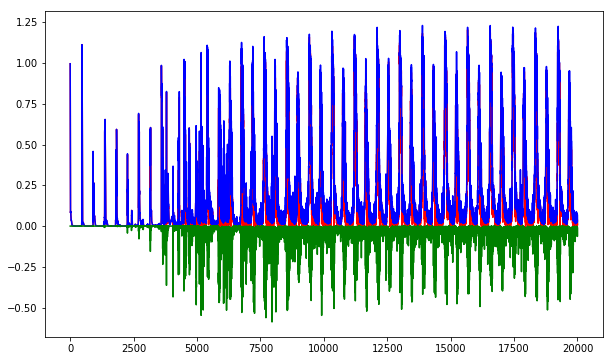

In [53]:
loss = []
cross_modal = []
diversity = []
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
distance = nn.CosineEmbeddingLoss()
iterations = 20000
optimizer_audio = torch.optim.SGD(model_audio.parameters(),weight_decay=0.0005,momentum=0.9,lr=0.01)
optimizer_video = torch.optim.SGD(model_video.parameters(),weight_decay=0.0005,momentum=0.9,lr=0.01)
optimizer_text = torch.optim.SGD(model_text.parameters(),weight_decay=0.0005,momentum=0.9,lr=0.01)

for iteration in range(iterations):
    

    i,j = sample(range(0,8148),2)
    
    ai = torch.unsqueeze(concat_audio[i],0).cuda()
    aj = torch.unsqueeze(concat_audio[j],0).cuda()
    
    vi = torch.unsqueeze(concat_video[i],0).cuda()
    vj = torch.unsqueeze(concat_video[j],0).cuda()
    
    ti = torch.unsqueeze(concat_text[i],0).cuda()
    tj = torch.unsqueeze(concat_text[j],0).cuda()
    
    optimizer_audio.zero_grad()
    optimizer_video.zero_grad()
    
    Ai = model_audio(ai)
    Aj = model_audio(aj)
    
    Vi = model_video(vi)
    Vj = model_video(vj)
    
    Ti = model_text(ti)
    Tj = model_text(tj)
    
    Ai = torch.unsqueeze(Ai,0)
    Aj = torch.unsqueeze(Aj,0)
    
    Vi = torch.unsqueeze(Vi,0)
    Vj = torch.unsqueeze(Vj,0)
    
    Ti = torch.unsqueeze(Ti,0)
    Tj = torch.unsqueeze(Tj,0)

    
    cross_modal_loss = (1.0/6)*(distance(Ai,Vi,torch.ones(1).cuda()) + distance(Aj,Vj,torch.ones(1).cuda()) +
                             distance(Ai,Ti,torch.ones(1).cuda()) + distance(Aj,Tj,torch.ones(1).cuda()) +
                               distance(Ti,Vi,torch.ones(1).cuda()) + distance(Tj,Vj,torch.ones(1).cuda()))
    diversity_loss = -(1.0/3)*(distance(Ai,Aj,torch.ones(1).cuda()) + 
                           distance(Vi,Vj,torch.ones(1).cuda()) + 
                           distance(Ti,Tj,torch.ones(1).cuda()))
    
    
    total_loss = cross_modal_loss + diversity_loss
    loss.append(total_loss)
    cross_modal.append(cross_modal_loss)
    diversity.append(diversity_loss)
    
    total_loss.backward()
    optimizer_audio.step()
    optimizer_video.step()
    optimizer_text.step()
    
    if(iteration%1000 == 0):
        print("iteration :",iteration," loss :",total_loss.item())
    
plt.plot(loss,'r',cross_modal,'b',diversity,'g')
plt.show()

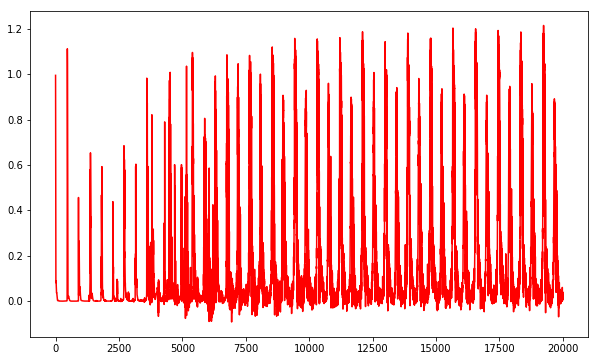

In [54]:
plt.plot(loss,'r')
plt.show()

In [0]:
new_train_audio = []
new_test_audio = []
new_valid_audio = []
for i in range(Train_audio.shape[0]):
    new_train_audio.append(model_audio(torch.unsqueeze(torch.from_numpy(Train_audio[i]).float().cuda(),0)).cpu().detach().numpy())
for i in range(Test_audio.shape[0]):
    new_test_audio.append(model_audio(torch.unsqueeze(torch.from_numpy(Test_audio[i]).float().cuda(),0)).cpu().detach().numpy())    
for i in range(Valid_audio.shape[0]):
    new_valid_audio.append(model_audio(torch.unsqueeze(torch.from_numpy(Valid_audio[i]).float().cuda(),0)).cpu().detach().numpy())
    
new_train_audio = np.array(new_train_audio)
new_test_audio = np.array(new_test_audio)
new_valid_audio = np.array(new_valid_audio)

In [0]:
new_train_video = []
new_test_video = []
new_valid_video = []
for i in range(Train_video.shape[0]):
    new_train_video.append(model_video(torch.unsqueeze(torch.from_numpy(Train_video[i]).float().cuda(),0)).cpu().detach().numpy())
for i in range(Test_video.shape[0]):
    new_test_video.append(model_video(torch.unsqueeze(torch.from_numpy(Test_video[i]).float().cuda(),0)).cpu().detach().numpy())    
for i in range(Valid_video.shape[0]):
    new_valid_video.append(model_video(torch.unsqueeze(torch.from_numpy(Valid_video[i]).float().cuda(),0)).cpu().detach().numpy())
    
new_train_video = np.array(new_train_video)
new_test_video = np.array(new_test_video)
new_valid_video = np.array(new_valid_video)

In [0]:
new_train_text = []
new_test_text = []
new_valid_text = []
for i in range(Train_text.shape[0]):
    new_train_text.append(model_text(torch.unsqueeze(torch.from_numpy(Train_text[i]).float().cuda(),0)).cpu().detach().numpy())
for i in range(Test_text.shape[0]):
    new_test_text.append(model_text(torch.unsqueeze(torch.from_numpy(Test_text[i]).float().cuda(),0)).cpu().detach().numpy())    
for i in range(Valid_text.shape[0]):
    new_valid_text.append(model_text(torch.unsqueeze(torch.from_numpy(Valid_text[i]).float().cuda(),0)).cpu().detach().numpy())
    
new_train_text = np.array(new_train_text)
new_test_text = np.array(new_test_text)
new_valid_text = np.array(new_valid_text)

In [0]:
new_test_audio = np.squeeze(new_test_audio)
new_valid_audio = np.squeeze(new_valid_audio)
new_train_audio = np.squeeze(new_train_audio)

new_test_text = np.squeeze(new_test_text)
new_valid_text = np.squeeze(new_valid_text)
new_train_text = np.squeeze(new_train_text)

new_test_video = np.squeeze(new_test_video)
new_valid_video = np.squeeze(new_valid_video)
new_train_video = np.squeeze(new_train_video)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total params: 4,550
Trainable params: 4,550
Non-trainable params: 0
_________________________________________________________________
None
Train on 6373 samples, validate on 1775 samples
Epoch 1/100
6373/6373 [==============================] - 0s 57us/step - loss: 1.2636 - acc: 0.1859 - val_loss: 1.2973 - val_acc: 0.1797
Epoch 2/100
6373/6373 [==============================] - 0s 26us/step - loss: 1.2591 - acc: 0.1938 - val_loss: 1.2897 - val_acc: 0.1797
Epoch 3/100
6373/6373 [==============================] - 0s 25us/step - loss: 1

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


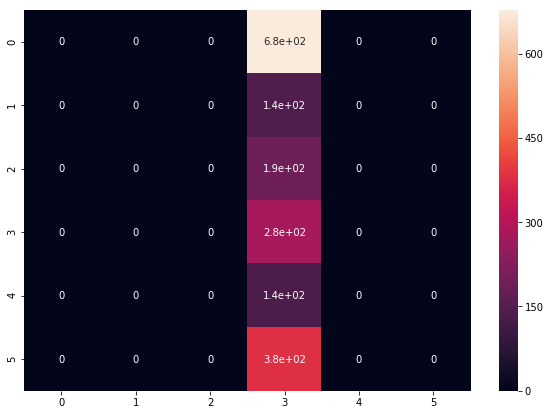

In [44]:

i = Input(shape=(64,))
x = Dense(64,activation='relu')(i)
o = Dense(6,activation='softmax')(x)
model = Model(i,o)
model.compile('adam','categorical_crossentropy',metrics=['accuracy'])
print(model.summary())
es = EarlyStopping(monitor='val_acc',mode='max' ,patience=5, min_delta=0.0001,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2,patience=2,min_lr=0.00001)
model.fit(new_train_audio,Y_train,128,epochs=100,validation_data=(new_valid_audio,Y_valid),callbacks=[es,reduce_lr])
print(model.evaluate(new_test_audio,Y_test))


print("###############################################################")
y_pred = np.argmax(model.predict(new_test_audio),axis=1)
y_true = np.argmax(Y_test,axis=1)
cm = confusion_matrix(y_true,y_pred)
np.save("cm_audio.npy",cm)
df = pd.DataFrame(cm)
plt.figure(figsize = (10,7),)
print("UNIMODAL AUDIO RESULTS")
print(classification_report(y_true,y_pred,target_names=target_names))
sn.heatmap(cm, annot=True,xticklabels=True,yticklabels=True)

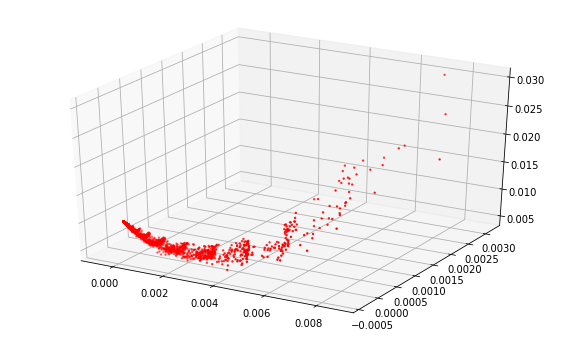

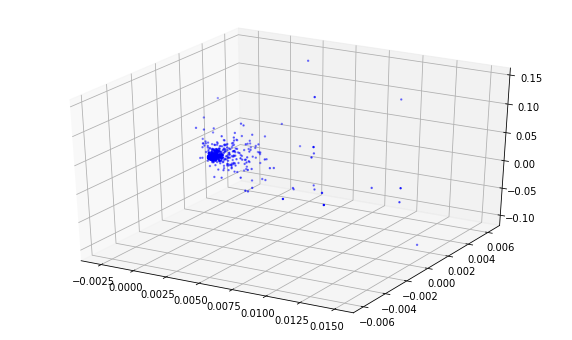

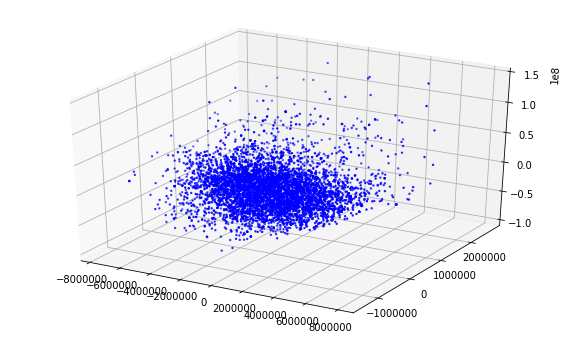

In [45]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)  

aud_pca = pca.fit_transform(new_train_audio) 
x=aud_pca[:,0]
y=aud_pca[:,1]
z=aud_pca[:,2]*100
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z,s=2,c='r')

pca = PCA(n_components=3)  
aud_pca = pca.fit_transform(new_train_video) 
x=aud_pca[:,0]
y=aud_pca[:,1]
z=aud_pca[:,2]*100
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z,s=2,c='b')

pca = PCA(n_components=3)  
aud_pca = pca.fit_transform(new_train_text) 
x=aud_pca[:,0]
y=aud_pca[:,1]
z=aud_pca[:,2]*100
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z,s=2,c='b')
plt.show()